<a href="https://colab.research.google.com/github/tamara-kostova/IIS/blob/master/recommender_lastfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages and import libraries

In [9]:
!pip install torch_geometric

In [10]:
!pip install torch torchvision

In [3]:
!pip install networkx

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import torch
from torch import optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, negative_sampling
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from datetime import datetime

# Load the dataset

In [171]:
artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/artists.dat', sep='\t', names=['id', 'name', 'url', 'pictureURL'])
tags_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/tags.dat', sep='\t', names=['tagID', 'tagValue'], encoding='latin-1')
user_artists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_artists.dat', sep='\t', names=['userID', 'artistID', 'weight'])
user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])
user_friends_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_friends.dat', sep='\t', names=['userID', 'friendID'])

<ipython-input-171-85a2bb2aba58>:4: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])


## Explore the dataset

In [ ]:
artists_df.head()

id               name                                         url  \
0  id               name                                         url   
1   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
2   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
3   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
4   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   

                                          pictureURL  
0                                         pictureURL  
1    http://userserve-ak.last.fm/serve/252/10808.jpg  
2  http://userserve-ak.last.fm/serve/252/3052066.jpg  
3  http://userserve-ak.last.fm/serve/252/40222717...  
4  http://userserve-ak.last.fm/serve/252/54697835...

In [ ]:
artists_df.describe()

id   name    url  pictureURL
count   17633  17633  17633       17189
unique  17633  17633  17633       17189
top        id   name    url  pictureURL
freq        1      1      1           1

In [ ]:
user_artists_df.head()

userID  artistID  weight
0  userID  artistID  weight
1       2        51   13883
2       2        52   11690
3       2        53   11351
4       2        54   10300

In [ ]:
user_artists_df.describe()

userID artistID weight
count   92835    92835  92835
unique   1893    17633   5437
top      1030       89      1
freq       50      611    636

In [ ]:
user_taggedartists_df.head()

userID  artistID  tagID  day  month  year
0  userID  artistID  tagID  day  month  year
1       2        52     13    1      4  2009
2       2        52     15    1      4  2009
3       2        52     18    1      4  2009
4       2        52     21    1      4  2009

In [ ]:
user_taggedartists_df.describe()

userID artistID   tagID     day   month    year
count   186480   186480  186480  186480  186480  186480
unique    1894    18589   11170       8      25      19
top       1672      289      73       1       8    2010
freq      2609      701    5325  128480   12704   37474

### Distribution of Users' Listening Counts

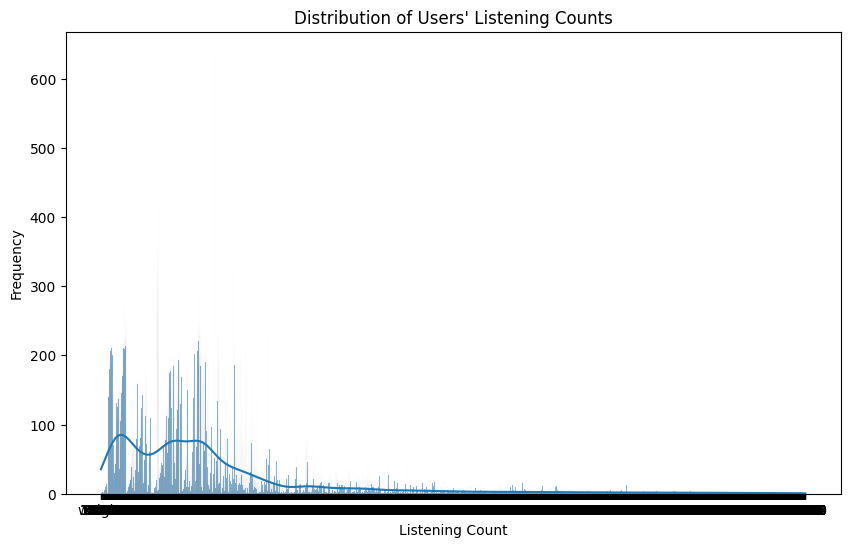

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(user_artists_df['weight'], bins=10, kde=True)
plt.title("Distribution of Users' Listening Counts")
plt.xlabel('Listening Count')
plt.ylabel('Frequency')
plt.show()

### Filter interactions with numeric weights

In [ ]:
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [ ]:
user_artists_df = user_artists_df[user_artists_df['weight'].apply(is_numeric)]

In [ ]:
user_artists_df['weight'] = user_artists_df['weight'].astype(float)

<ipython-input-9-e9cc85b330ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_artists_df['weight'] = user_artists_df['weight'].astype(float)


### Top 10 Most Listened Artists

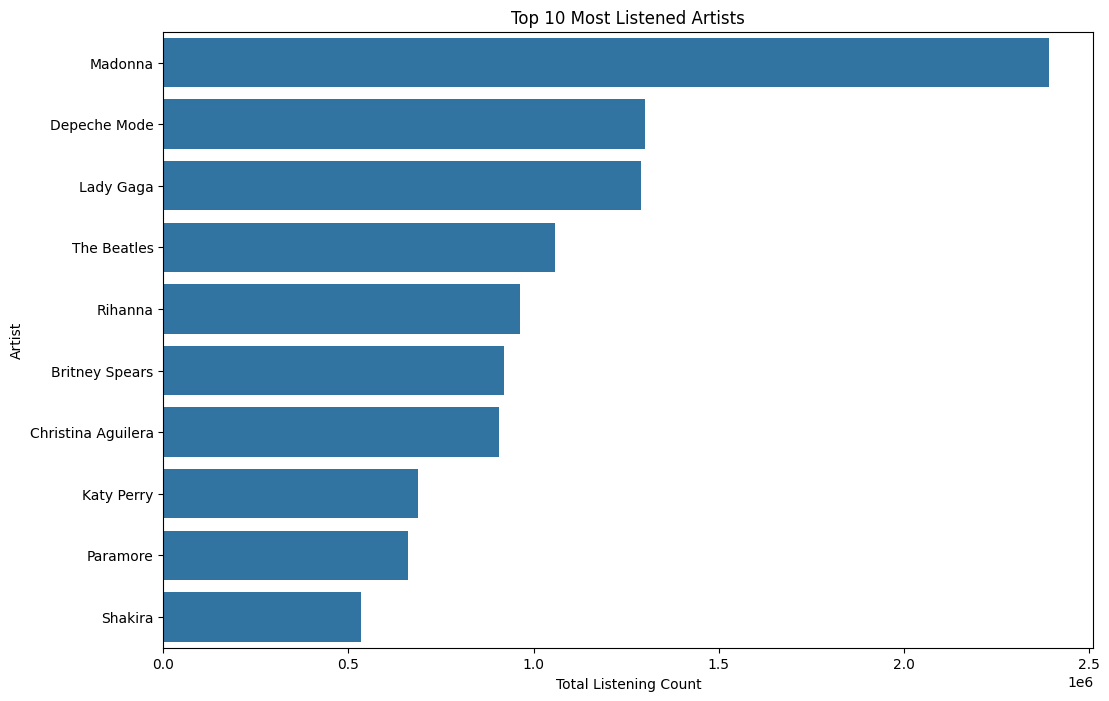

In [ ]:
top_artists = user_artists_df.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_names = artists_df[artists_df['id'].isin(top_artists.index)]['name']

plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists_names)
plt.title('Top 10 Most Listened Artists')
plt.xlabel('Total Listening Count')
plt.ylabel('Artist')
plt.show()

### Number of Fans Artists Have

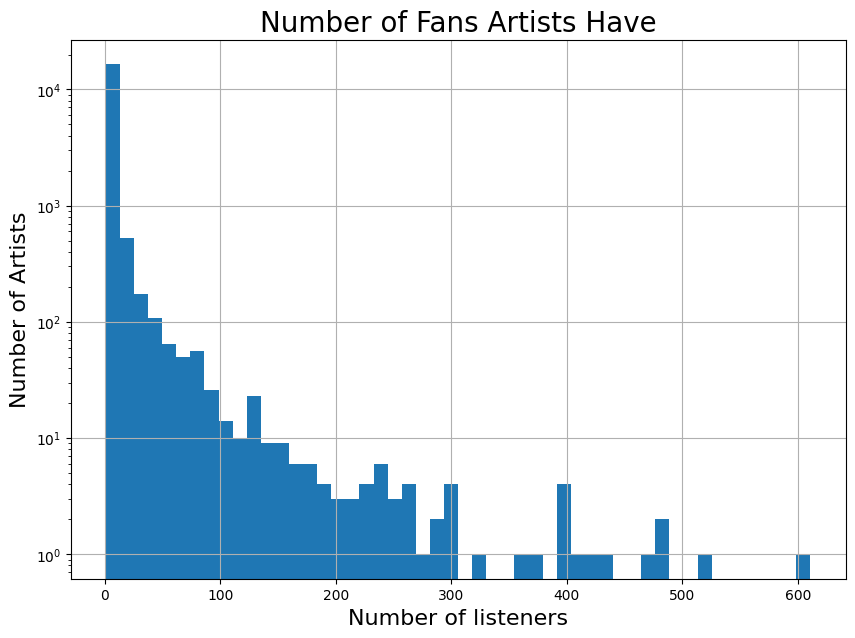

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
user_artists_df.groupby("artistID")["userID"].nunique().hist(bins=50, ax=ax)
plt.title("Number of Fans Artists Have", fontsize=20)
plt.xlabel("Number of listeners", fontsize=16)
plt.ylabel("Number of Artists", fontsize=16)
plt.yscale("log")
plt.show()

### User Friendships Network

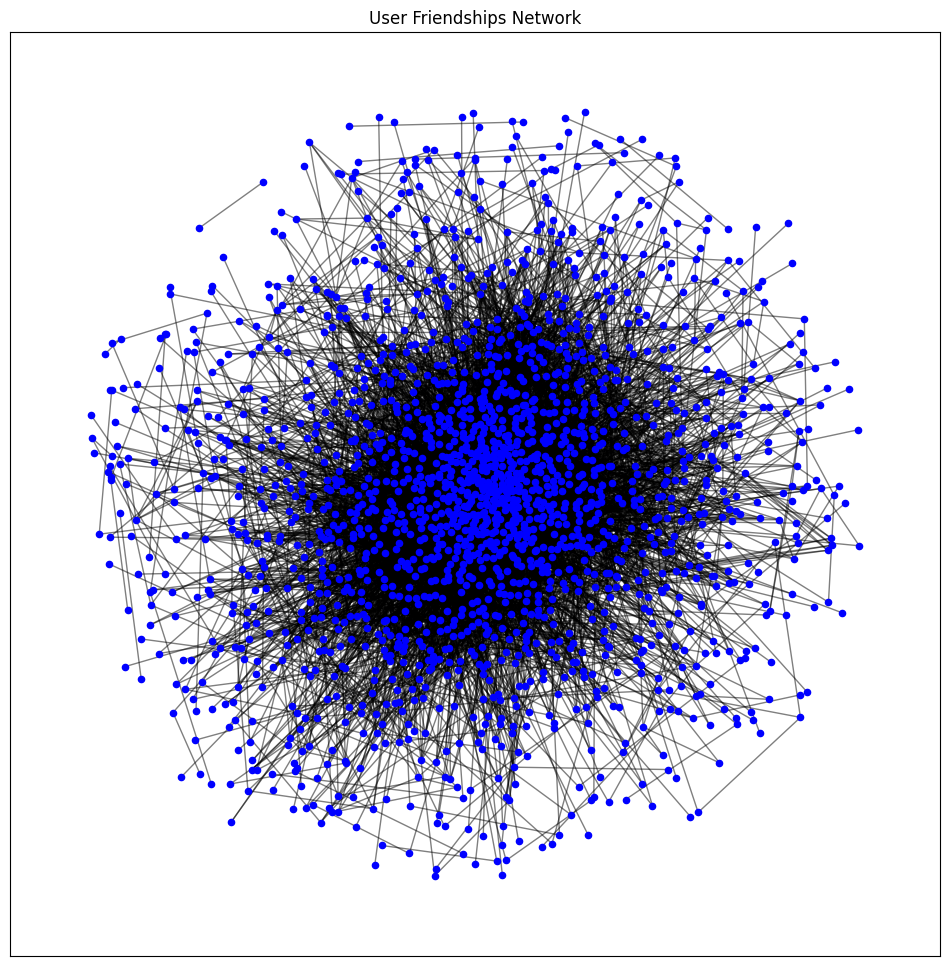

In [ ]:
G = nx.from_pandas_edgelist(user_friends_df, 'userID', 'friendID')

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.2)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('User Friendships Network')
plt.show()

### Number of Friends Users Have

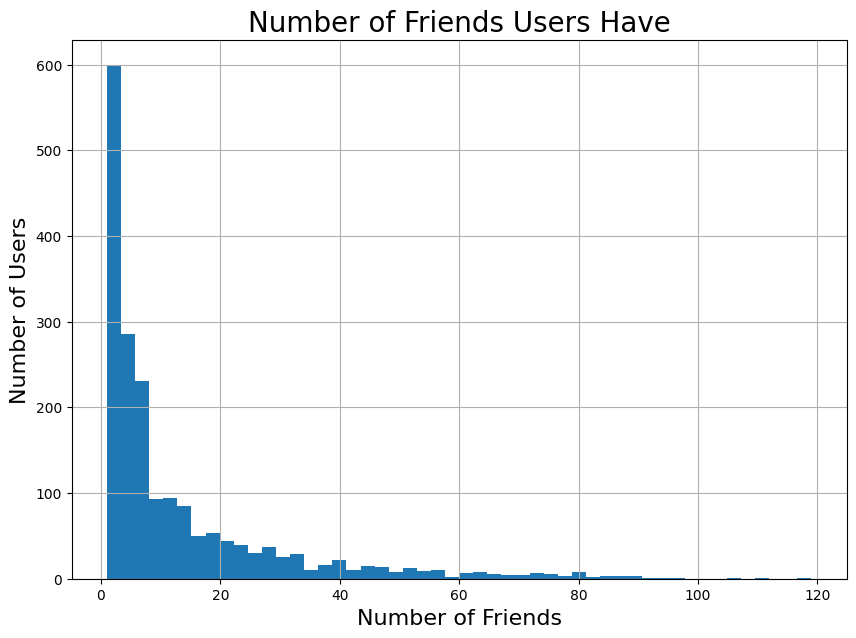

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
user_friends_df.groupby("userID")["friendID"].nunique().hist(bins=50, ax=ax)
plt.title("Number of Friends Users Have", fontsize=20)
plt.ylabel("Number of Users", fontsize=16)
plt.xlabel("Number of Friends", fontsize=16)
plt.show()

### Heatmap of User-Artist Interactions

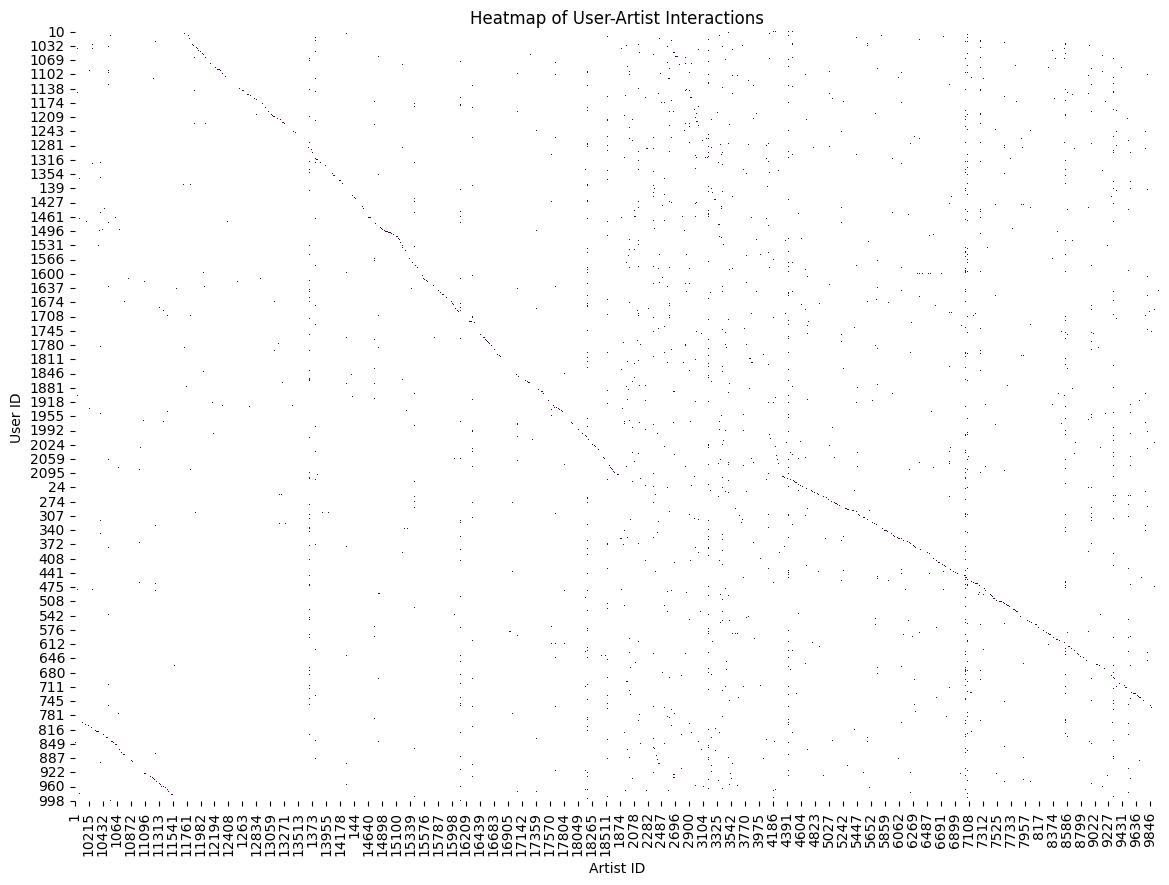

In [ ]:
interaction_matrix = user_artists_df.pivot(index='userID', columns='artistID', values='weight')

plt.figure(figsize=(14, 10))
sns.heatmap(interaction_matrix, cmap='viridis', cbar=False)
plt.title('Heatmap of User-Artist Interactions')
plt.xlabel('Artist ID')
plt.ylabel('User ID')
plt.show()

# Additional exploration

In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/artists.dat', sep='\t', usecols=['id','name'])
user_artists = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_artists.dat', sep='\t')

In [ ]:
merged = pd.merge(artists,
                user_artists,
                how='inner',
                left_on='id',
                right_on='artistID')

merged = merged.rename(columns={"weight":"plays"})

merged.head()

id             name  userID  artistID  plays
0   1     MALICE MIZER      34         1    212
1   1     MALICE MIZER     274         1    483
2   1     MALICE MIZER     785         1     76
3   2  Diary of Dreams     135         2   1021
4   2  Diary of Dreams     257         2    152

In [ ]:
artist_rank = (merged.groupby(['name']).agg({'userID':'count','plays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"plays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']

user_rank = (merged.groupby(['userID']).agg({'name':'count','plays':'sum'}).
    rename(columns={"name":'totalUniqueArtists',"plays":"totalUserPlays"}).
            sort_values(['totalUserPlays'],ascending=False))

In [ ]:
artist_rank.head()

totalUniqueUsers  totalArtistPlays  avgUserPlays
name                                                                
Britney Spears                   522           2393140   4584.559387
Depeche Mode                     282           1301308   4614.567376
Lady Gaga                        611           1291387   2113.563011
Christina Aguilera               407           1058405   2600.503686
Paramore                         399            963449   2414.659148

In [ ]:
user_rank.head()

totalUniqueArtists  totalUserPlays
userID                                    
757                     50          480039
2000                    50          468409
1418                    50          416349
1642                    50          388251
1094                    50          379125

### Join all tables

In [ ]:
merged = merged.join(artist_rank,on='name', how='inner')
final = merged.join(user_rank,on='userID', how='inner').sort_values(['plays'],ascending=False)

# confirm no duplicated rows
assert final[final.duplicated(['userID','name'])].empty

In [ ]:
final.head()

id          name  userID  artistID   plays  totalUniqueUsers  \
2800    72  Depeche Mode    1642        72  352698               282   
35843  792        Thalía    2071       792  324663                26   
27302  511            U2    1094       511  320725               185   
8152   203          Blur    1905       203  257978               114   
26670  498      Paramore    1664       498  227829               399   

       totalArtistPlays  avgUserPlays  totalUniqueArtists  totalUserPlays  
2800            1301308   4614.567376                  50          388251  
35843            350035  13462.884615                  50          338400  
27302            493024   2664.994595                  50          379125  
8152             318221   2791.412281                  50          276295  
26670            963449   2414.659148                  50          251560

# Graph

In [44]:
G = nx.Graph()

In [45]:
users = set(user_artists_df['userID'])
artists = set(user_artists_df['artistID'])

## Add nodes

### users

In [51]:
G.add_nodes_from(users, bipartite=0, type='user')

In [60]:
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
print(f"Number of user nodes: {len(user_nodes)}")

Number of user nodes: 1893


### artists

In [47]:
G.add_nodes_from(artists, bipartite=1, type='artist')

In [53]:
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']
print(f"Number of artist nodes: {len(artist_nodes)}")


Number of artist nodes: 15753


## Add edges

Remove non-numeric edges

In [48]:
def clean_edge_weights(G):
    for u, v, data in G.edges(data=True):
        if 'weight' in data:
            try:
                data['weight'] = float(data['weight'])
            except ValueError:
                G.remove_edge(u, v)
                print(f"Removed edge ({u}, {v}) with invalid weight: {data['weight']}")

In [57]:
user_artists_df = user_artists_df[1:]

In [58]:
for _, row in user_artists_df.iterrows():
    G.add_edge(row['userID'], row['artistID'], weight=float(row['weight']), relation='listens')

# Visualization

In [59]:
clean_edge_weights(G)

In [ ]:
pos = nx.spring_layout(G, seed=42, k=0.5)

In [ ]:
len(users)

1892

In [ ]:
default_node_attrs = {'type': 'unknown'}

# Check all nodes and add missing attributes with default values
for node in G.nodes():
    for attr in default_node_attrs:
        if attr not in G.nodes[node]:
            G.nodes[node][attr] = default_node_attrs[attr]

# Set attributes for users and artists
for user in users:
    G.nodes[user]['type'] = 'user'

for artist in artists:
    G.nodes[artist]['type'] = 'artist'

In [ ]:
# Separate users and artists
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']

# Define node colors and shapes
node_colors = []
node_shapes = []
for node in G.nodes:
    if node in user_nodes:
        node_colors.append('lightblue')
        node_shapes.append('o')
    else:
        node_colors.append('lightgreen')
        node_shapes.append('s')

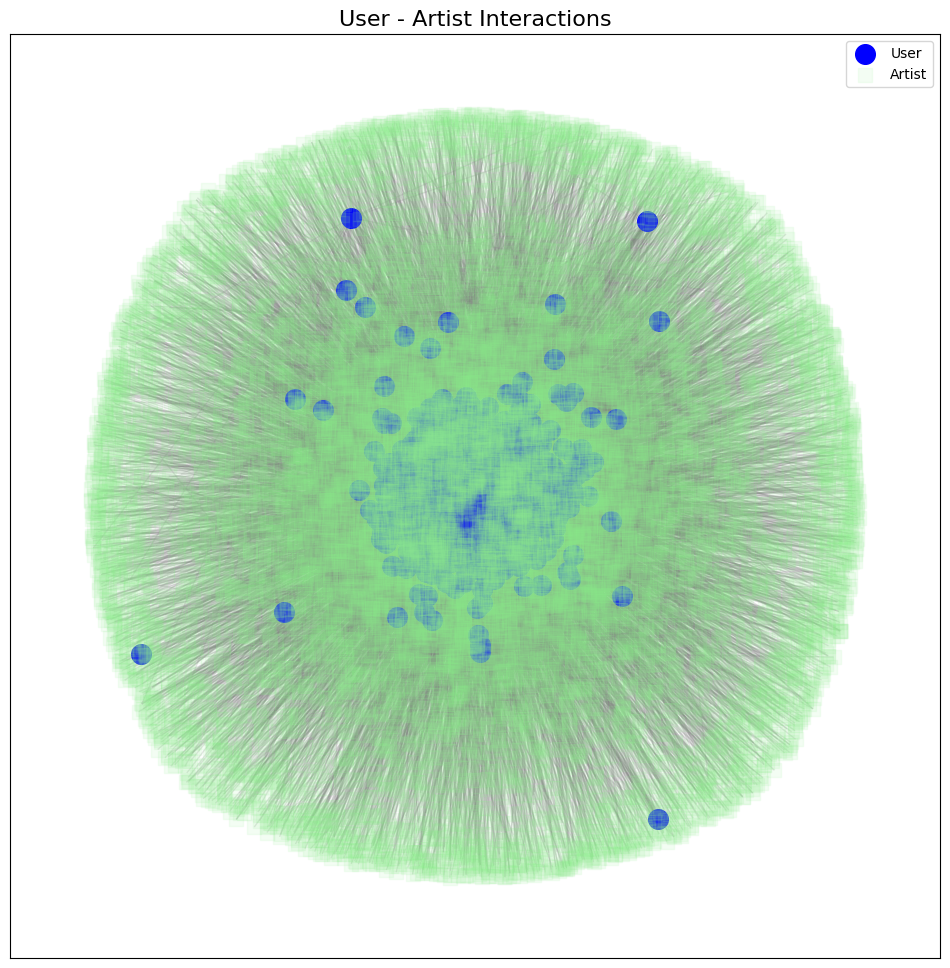

In [ ]:
plt.figure(figsize=(12, 12))

# Draw users
nx.draw_networkx_nodes(
    G, pos,
    nodelist=user_nodes,
    node_color='blue',
    node_shape='o',
    node_size=200,
    label='User',
    alpha=1
)

# Draw artists
nx.draw_networkx_nodes(
    G, pos,
    nodelist=artist_nodes,
    node_color='lightgreen',
    node_shape='s',
    node_size=100,
    label='Artist',
    alpha = 0.1
)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.2)

# Draw labels
# nx.draw_networkx_labels(G, pos, font_size=8,
#     font_color='black',  # Change label color
#     # font_weight='bold',  # Change label weight
#     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title('User - Artist Interactions', fontsize=16)
plt.legend(['User', 'Artist'], loc='best')
plt.show()

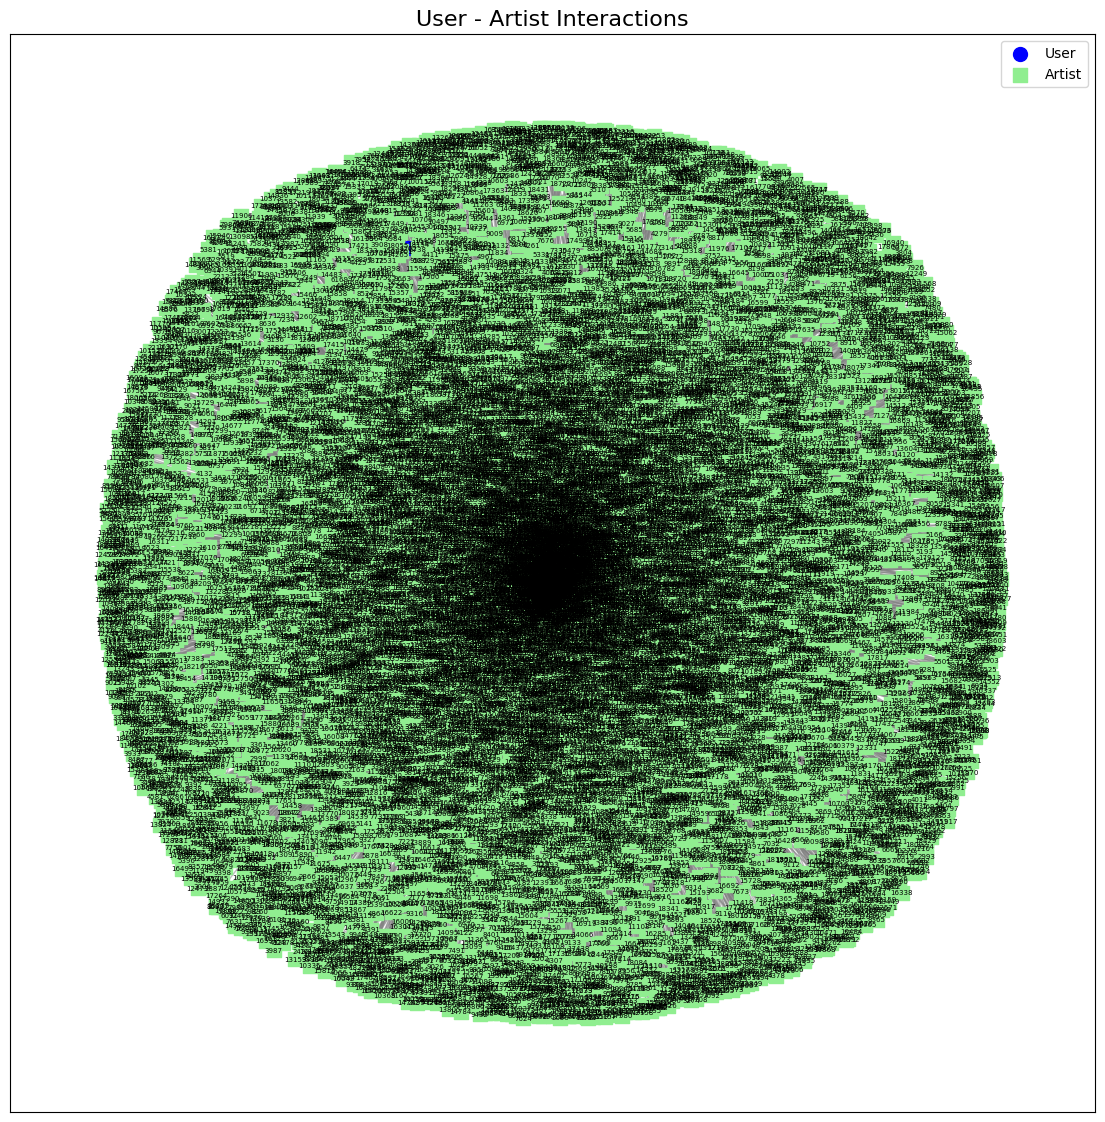

In [ ]:
# Separate users and artists
user_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'user']
artist_nodes = [node for node in G.nodes if G.nodes[node].get('type') == 'artist']

# Define colors and shapes
node_colors = ['blue' if node in user_nodes else 'lightgreen' for node in G.nodes]
node_shapes = ['o' if node in user_nodes else 's' for node in G.nodes]

plt.figure(figsize=(14, 14))

# Draw nodes with different shapes and colors
for shape, color, nodes in zip(['o', 's'], ['blue', 'lightgreen'], [user_nodes, artist_nodes]):
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_color=color,
        node_shape=shape,
        node_size=100,
        label='User' if shape == 'o' else 'Artist'
    )

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=5)

plt.title('User - Artist Interactions', fontsize=16)
plt.legend(['User', 'Artist'], loc='best')
plt.show()


# GNN models

### Train and test functions

In [123]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [124]:
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    accuracy = int(correct) / int(mask.sum())
    return accuracy

In [141]:
def train_model(model, data, model_name):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0
    patience = 20
    counter = 0

    for epoch in range(500):
        loss = train(model, data, optimizer, criterion)
        train_acc = test(model, data, data.train_mask)
        val_acc = test(model, data, data.val_mask)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
        else:
            counter += 1

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

        if counter >= patience:
            print("Early stopping")
            break

    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))

    # Evaluate on test set
    test_acc = test(model, data, data.test_mask)
    print(f'{model_name} Test Accuracy: {test_acc:.4f}')

    return model

In [142]:
def get_recommendations(user_ids, model, data, top_k=5):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        embeddings = out.numpy()

        user_indices = [i for i, (_, attr) in enumerate(G.nodes(data=True)) if attr['type'] == 'user']
        artist_indices = [i for i, (_, attr) in enumerate(G.nodes(data=True)) if attr['type'] == 'artist']

        recommendations = {}
        for user in user_ids:
            if user not in user_indices:
                continue
            user_embedding = embeddings[user]
            similarities = []
            for artist in artist_indices:
                artist_embedding = embeddings[artist]
                sim = np.dot(user_embedding, artist_embedding) / (np.linalg.norm(user_embedding) * np.linalg.norm(artist_embedding))
                similarities.append((artist, sim))
            similarities.sort(key=lambda x: x[1], reverse=True)
            top_artists = [artist for artist, _ in similarities[:top_k]]
            recommendations[user] = top_artists
        return recommendations

## Prepare graph data for models

In [64]:
pyg_data = from_networkx(G)

In [ ]:
pyg_data

Data(edge_index=[2, 184760], bipartite=[17644], type=[17644], weight=[184760], relation=[184760], num_nodes=17644)

In [65]:
num_nodes = pyg_data.num_nodes
indices = torch.randperm(num_nodes)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size+val_size]] = True
test_mask[indices[train_size+val_size:]] = True
pyg_data.train_mask = train_mask
pyg_data.val_mask = val_mask
pyg_data.test_mask = test_mask

In [66]:
num_features = 16
pyg_data.x = torch.randn((num_nodes, num_features))

# Create labels based on 'type' attribute
node_types = [G.nodes[node]['type'] for node in G.nodes()]
labels = torch.zeros(num_nodes, dtype=torch.long)
for i, node_type in enumerate(node_types):
    labels[i] = 0 if node_type == 'user' else 1
pyg_data.y = labels

# Ensure correct size and dtype
print(labels)

tensor([0, 0, 0,  ..., 1, 1, 1])


### Map artist ids to artist names

In [175]:
artists_df['id'] = pd.to_numeric(artists_df['id'], errors='coerce')
artists_df = artists_df.dropna(subset=['id'])
artists_df['id'] = artists_df['id'].astype(int)

def map_recommendations(recommendations, artists_df):
    mapped_recommendations = {}
    for user_id, artist_ids in recommendations.items():
        mapped_artists = []
        for artist_id in artist_ids:
            # Try to find the artist name
            artist_name = artists_df[artists_df['id'] == artist_id]['name'].values
            if len(artist_name) > 0:
                mapped_artists.append(artist_name[0])
            else:
                # If not found, use the original ID
                mapped_artists.append(f"Unknown (ID: {artist_id})")
        mapped_recommendations[user_id] = mapped_artists
    return mapped_recommendations

<ipython-input-175-3c228abf706f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_df['id'] = artists_df['id'].astype(int)


### GCN Model

In [145]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

### SAGE Model

In [146]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

### Graph Attention Model

In [150]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

### Initialize models

In [147]:
models = {
    'GCN': GCN(num_features=num_features, hidden_channels=32, num_classes=2),
    'GraphSAGE': GraphSAGE(num_features=num_features, hidden_channels=32, num_classes=2),
    'GAT': GAT(num_features=num_features, hidden_channels=32, num_classes=2)
}

In [144]:
trained_models = {}

### Train models

In [148]:
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    trained_models[model_name] = train_model(model, pyg_data, model_name)


Training GCN...
Epoch 0, Loss: 0.6476, Train Accuracy: 0.8650, Val Accuracy: 0.8629
Epoch 10, Loss: 0.6253, Train Accuracy: 0.8914, Val Accuracy: 0.8906
Epoch 20, Loss: 0.6060, Train Accuracy: 0.8927, Val Accuracy: 0.8912
Epoch 30, Loss: 0.5911, Train Accuracy: 0.8927, Val Accuracy: 0.8912
Early stopping
GCN Test Accuracy: 0.8943

Training GraphSAGE...
Epoch 0, Loss: 0.6459, Train Accuracy: 0.7153, Val Accuracy: 0.6979
Epoch 10, Loss: 0.5107, Train Accuracy: 0.8595, Val Accuracy: 0.8558
Epoch 20, Loss: 0.4315, Train Accuracy: 0.8894, Val Accuracy: 0.8875
Epoch 30, Loss: 0.3895, Train Accuracy: 0.8926, Val Accuracy: 0.8912
Epoch 40, Loss: 0.3636, Train Accuracy: 0.8927, Val Accuracy: 0.8912
Early stopping
GraphSAGE Test Accuracy: 0.8943

Training GAT...
Epoch 0, Loss: 0.7942, Train Accuracy: 0.5368, Val Accuracy: 0.5395
Epoch 10, Loss: 0.5492, Train Accuracy: 0.8902, Val Accuracy: 0.8892
Epoch 20, Loss: 0.5114, Train Accuracy: 0.8927, Val Accuracy: 0.8912
Epoch 30, Loss: 0.5024, Train 

### Make recommendations with the trained models

In [176]:
for model_name, model in trained_models.items():
    print(f"\nRecommendations from {model_name}:")
    recommendations = get_recommendations([2], model, pyg_data)
    mapped_recommendations = map_recommendations(recommendations, artists_df)
    print(mapped_recommendations)


Recommendations from GCN:
{2: ['Anal Nosorog', 'The Flying Burrito Brothers', 'Winter Gloves', 'Массква', 'Unknown (ID: 6418)']}

Recommendations from GraphSAGE:
{2: ['[unknown]', 'Unknown (ID: 7001)', 'HAKUEI', 'XIV Dark Centuries', 'Unknown (ID: 12304)']}

Recommendations from GAT:
{2: ['Sahara Hotnights', 'Orelsan', 'Tsunami Wazahari', 'The Gathering', 'Radial Angel']}


## Include similarity between users when doing recommendations

In [151]:
def get_user_interactions(G):
    user_ids = [node for node in G.nodes if G.nodes[node]['type'] == 'user']
    artist_ids = [node for node in G.nodes if G.nodes[node]['type'] == 'artist']

    user_index = {user: idx for idx, user in enumerate(user_ids)}
    artist_index = {artist: idx for idx, artist in enumerate(artist_ids)}

    interactions_matrix = np.zeros((len(user_ids), len(artist_ids)))

    for user in user_ids:
        for artist in artist_ids:
            if G.has_edge(user, artist):
                interactions_matrix[user_index[user], artist_index[artist]] = 1

    return interactions_matrix, user_index, artist_index

In [152]:
def compute_user_similarities(interactions_matrix):
    similarity_matrix = cosine_similarity(interactions_matrix)
    return similarity_matrix

In [153]:
def recommend_similarity(user_ids, interactions_matrix, similarity_matrix, user_index, artist_index, top_k=5):
    recommendations = {}

    for user_id in user_ids:
        if user_id not in user_index:
            print(f"User ID {user_id} not found in user_index.")
            continue

        user_idx = user_index[user_id]
        user_similarities = similarity_matrix[user_idx]
        similar_users = np.argsort(-user_similarities)

        recommended_artists = set()

        for similar_user_idx in similar_users:
            if similar_user_idx == user_idx:
                continue

            similar_user_id = [user for user, idx in user_index.items() if idx == similar_user_idx][0]
            interacted_artists = np.where(interactions_matrix[similar_user_idx] == 1)[0]

            for artist_idx in interacted_artists:
                if interactions_matrix[user_idx, artist_idx] == 0:
                    recommended_artists.add(artist_idx)

        # Convert artist indices to artist IDs
        recommended_artists_ids = [artist for artist, idx in artist_index.items() if idx in recommended_artists]
        recommendations[user_id] = recommended_artists_ids[:top_k]

    return recommendations

In [154]:
interactions_matrix, user_index, artist_index = get_user_interactions(G)
interactions_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [155]:
similarity_matrix = compute_user_similarities(interactions_matrix)
similarity_matrix

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.13363062, 0.27216553,
        0.        ],
       ...,
       [0.        , 0.        , 0.13363062, ..., 1.        , 0.10910895,
        0.        ],
       [0.        , 0.        , 0.27216553, ..., 0.10910895, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [158]:
similarity_recommendations = recommend_similarity(['2'], interactions_matrix, similarity_matrix, user_index, artist_index)
print(recommendations)

{2: [2142, 2246, 3136, 3901, 4743]}


In [159]:
mapped_similarity_recommendations = map_recommendations(similarity_recommendations)
print("\nRecommendations from Similarity-based approach:")
print(mapped_similarity_recommendations)


Recommendations from Similarity-based approach:
{'2': ['Bodhisattva 13:20', 'Grammatics', 'Four Jacks', 'Airiel', 'Medicine']}


# Evaluate the models for "future" recommendation based on chosen timestamp

 ### Split Data Based on Timestamp

In [ ]:
user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'timestamp'])
user_taggedartists_df.head()

<ipython-input-41-a5cf52998294>:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  user_taggedartists_df = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', sep='\t', names=['userID', 'artistID', 'tagID', 'timestamp'])


userID  artistID  tagID      timestamp
0  userID  artistID  tagID      timestamp
1       2        52     13  1238536800000
2       2        52     15  1238536800000
3       2        52     18  1238536800000
4       2        52     21  1238536800000

Timestamp is given in milliseconds so it needs to be converted

In [ ]:
user_taggedartists_df = user_taggedartists_df[1:]

In [ ]:
# Convert timestamps to datetime
user_taggedartists_df['datetime'] = pd.to_datetime(user_taggedartists_df['timestamp'], unit='ms')

# Define a point in time to split the data
split_time = pd.Timestamp('2010-01-01')

# Split data into past and future
past_interactions = user_taggedartists_df[user_taggedartists_df['datetime'] < split_time]
future_interactions = user_taggedartists_df[user_taggedartists_df['datetime'] >= split_time]

<ipython-input-46-b3ea94b8f8a3>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  user_taggedartists_df['datetime'] = pd.to_datetime(user_taggedartists_df['timestamp'], unit='ms')


In [ ]:
user_taggedartists_df.head()

userID artistID tagID      timestamp                datetime
1      2       52    13  1238536800000 2009-03-31 22:00:14.592
2      2       52    15  1238536800000 2009-03-31 22:00:14.592
3      2       52    18  1238536800000 2009-03-31 22:00:14.592
4      2       52    21  1238536800000 2009-03-31 22:00:14.592
5      2       52    41  1238536800000 2009-03-31 22:00:14.592

In [ ]:
past_interactions.head()

userID artistID tagID      timestamp                datetime
1      2       52    13  1238536800000 2009-03-31 22:00:14.592
2      2       52    15  1238536800000 2009-03-31 22:00:14.592
3      2       52    18  1238536800000 2009-03-31 22:00:14.592
4      2       52    21  1238536800000 2009-03-31 22:00:14.592
5      2       52    41  1238536800000 2009-03-31 22:00:14.592

In [ ]:
past_interactions.describe()

datetime
count                         119888
mean   2008-07-03 19:50:59.522731264
min       1956-05-31 23:00:09.856000
25%              2007-10-31 23:00:00
50%              2008-08-31 22:00:00
75%       2009-04-30 21:59:23.392000
max       2009-12-31 23:00:30.336000

In [ ]:
future_interactions.head()

userID artistID tagID      timestamp                datetime
46      3      101    14  1264978800000 2010-01-31 22:59:15.584
52      3      101    47  1264978800000 2010-01-31 22:59:15.584
57      3      101    52  1285884000000 2010-09-30 21:59:13.152
58      3      101    53  1272664800000 2010-04-30 22:00:17.664
62      3      101    57  1267398000000 2010-02-28 22:59:11.488

In [ ]:
future_interactions.describe()

datetime
count                          66591
mean   2010-08-23 14:14:10.180559872
min       2010-01-31 22:59:15.584000
25%       2010-04-30 22:00:17.664000
50%              2010-08-31 22:00:00
75%       2010-11-30 23:00:28.288000
max       2011-05-09 11:44:57.468000

## Build graph from past interactions only

In [ ]:
G_past = nx.Graph()

# Add nodes and edges for past interactions
for _, row in past_interactions.iterrows():
    user_id = int(row['userID'])
    artist_id = int(row['artistID'])
    if not G_past.has_node(user_id):
        G_past.add_node(user_id, type='user')
    if not G_past.has_node(artist_id):
        G_past.add_node(artist_id, type='artist')
    G_past.add_edge(user_id, artist_id)

# Convert to PyG data
pyg_data_past = from_networkx(G_past)

# Dummy node features and labels
pyg_data_past.x = torch.eye(pyg_data_past.num_nodes)
pyg_data_past.y = torch.tensor([0 if G_past.nodes[node].get('type') == 'user' else 1 for node in G_past.nodes], dtype=torch.long)

## Define and train the model

In [ ]:
class GCNmodel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNmodel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def train(model, pyg_data):
    model.train()
    optimizer.zero_grad()
    out = model(pyg_data.x, pyg_data.edge_index)
    loss = criterion(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    print(f'Accuracy: {accuracy:.4f}')

In [ ]:
def create_masks(data, cutoff_date):
    cutoff_date = datetime.strptime(cutoff_date, '%d-%m-%Y').timestamp()

    # Create masks
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    timestamps = data.timestamps

    for i in range(data.num_nodes):
        if timestamps[i] <= cutoff_date:
            data.train_mask[i] = True
        else:
            data.test_mask[i] = True

    return data

In [ ]:
from datetime import datetime
import torch
import pandas as pd

# Load timestamps from user_taggedartists.dat and convert to datetime
timestamps = []
with open('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists.dat', 'r') as f:
    for i, line in enumerate(f):
        if i == 0:
          continue
        _, _, _, day, month, year = line.strip().split('\t')
        timestamps.append(datetime(int(year), int(month), int(day)))

# Convert timestamps to datetime objects
timestamps = pd.to_datetime(timestamps)


In [ ]:
pyg_data_past = Data(x=pyg_data_past.x, edge_index=pyg_data_past.edge_index, y=pyg_data_past.y)

In [ ]:
pyg_data_past.timestamps = torch.tensor([timestamp.timestamp() for timestamp in timestamps], dtype=torch.float)

In [ ]:
pyg_data_past = create_masks(pyg_data_past, '01-01-2010')

In [ ]:
model = GCNmodel(in_channels=pyg_data_past.x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    loss = train(model, pyg_data_past)
    if epoch % 10 == 0:
      print(f'Epoch {epoch+1}, Loss: {loss}')
evaluate(model, pyg_data_past)

Epoch 1, Loss: 0.6925095319747925
Epoch 11, Loss: 0.39393723011016846
Epoch 21, Loss: 0.25116658210754395
Epoch 31, Loss: 0.22488972544670105
Epoch 41, Loss: 0.19982688128948212
Epoch 51, Loss: 0.17404887080192566
Epoch 61, Loss: 0.15529005229473114
Epoch 71, Loss: 0.14030730724334717
Epoch 81, Loss: 0.1287449300289154
Epoch 91, Loss: 0.12076012790203094
Epoch 101, Loss: 0.11515286564826965
Epoch 111, Loss: 0.11099840700626373
Epoch 121, Loss: 0.10765430331230164
Epoch 131, Loss: 0.1036328673362732
Epoch 141, Loss: 0.08237521350383759
Epoch 151, Loss: 0.06502348929643631
Epoch 161, Loss: 0.0526542104780674
Epoch 171, Loss: 0.04402594640851021
Epoch 181, Loss: 0.037764109671115875
Epoch 191, Loss: 0.03292999789118767
Accuracy: 0.8858


In [ ]:
def evaluate_recommendations(recommendations, future_interactions):
    correct = 0
    total = 0

    for user_id, artist_ids in recommendations.items():
        user_future_interactions = future_interactions[future_interactions['userID'] == int(user_id)]
        future_artist_ids = user_future_interactions['artistID'].unique()

        for artist_id in artist_ids:
            if artist_id in future_artist_ids:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

In [ ]:
user_ids = [i for i in range(1,1000)]
recommendations = get_recommendations(user_ids, model, pyg_data_past, top_k=5)
mapped_recommendations = map_recommendations(recommendations)
accuracy = evaluate_recommendations(recommendations, future_interactions)
print(f'Recommendation Accuracy: {accuracy:.4f}')

# Session based recommendations

## Exploration and analysis

Recommend music to users only based on what they have recently interacted with.

In [20]:
user_taggedartists_timestamps = pd.read_csv('/content/drive/MyDrive/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', sep='\t')

user_taggedartists_timestamps['datetime'] = pd.to_datetime(user_taggedartists_timestamps['timestamp'], unit='ms')

user_taggedartists_timestamps.sort_values(by=['userID', 'datetime'], inplace=True)

multiple_timestamps = user_taggedartists_timestamps.groupby('userID').size()

In [ ]:
df_multiple_timestamps = multiple_timestamps.reset_index()
df_multiple_timestamps.columns = ['userID', 'count_of_timestamps']

df_multiple_timestamps.head()

userID  count_of_timestamps
0       2                   45
1       3                   56
2       4                   61
3       5                   43
4       6                   14

### Number of timestamps per user

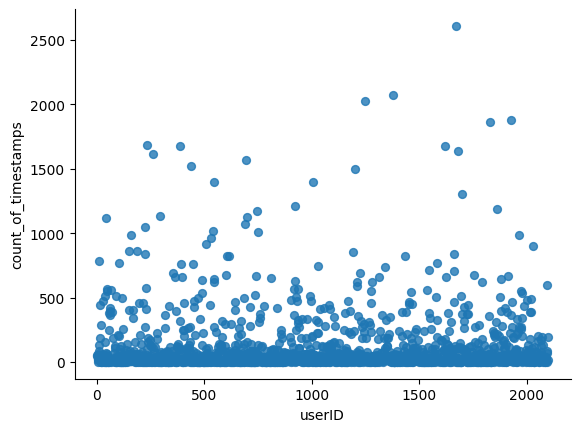

In [ ]:
df_multiple_timestamps.plot(kind='scatter', x='userID', y='count_of_timestamps', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_multiple_timestamps.describe()

userID  count_of_timestamps
count  1892.000000          1892.000000
mean   1038.433404            98.561839
std     610.409730           224.590646
min       2.000000             1.000000
25%     505.500000             7.000000
50%    1031.000000            20.000000
75%    1572.250000            70.250000
max    2100.000000          2609.000000

In [ ]:
user_taggedartists_timestamps['date'] = user_taggedartists_timestamps['datetime'].dt.date
user_taggedartists_timestamps['hour'] = user_taggedartists_timestamps['datetime'].dt.hour
user_taggedartists_timestamps['week'] = user_taggedartists_timestamps['datetime'].dt.isocalendar().week
user_taggedartists_timestamps['day'] = user_taggedartists_timestamps['datetime'].dt.day
user_taggedartists_timestamps['year'] = user_taggedartists_timestamps['datetime'].dt.year
user_taggedartists_timestamps['month'] = user_taggedartists_timestamps['datetime'].dt.month

In [ ]:
user_taggedartists_timestamps.head()

userID  artistID  tagID      timestamp            datetime        date  \
0       2        52     13  1238536800000 2009-03-31 22:00:00  2009-03-31   
1       2        52     15  1238536800000 2009-03-31 22:00:00  2009-03-31   
2       2        52     18  1238536800000 2009-03-31 22:00:00  2009-03-31   
3       2        52     21  1238536800000 2009-03-31 22:00:00  2009-03-31   
4       2        52     41  1238536800000 2009-03-31 22:00:00  2009-03-31   

   hour  week  day  year  
0    22    14   31  2009  
1    22    14   31  2009  
2    22    14   31  2009  
3    22    14   31  2009  
4    22    14   31  2009

### Plot the number of interactions over time for a specific user

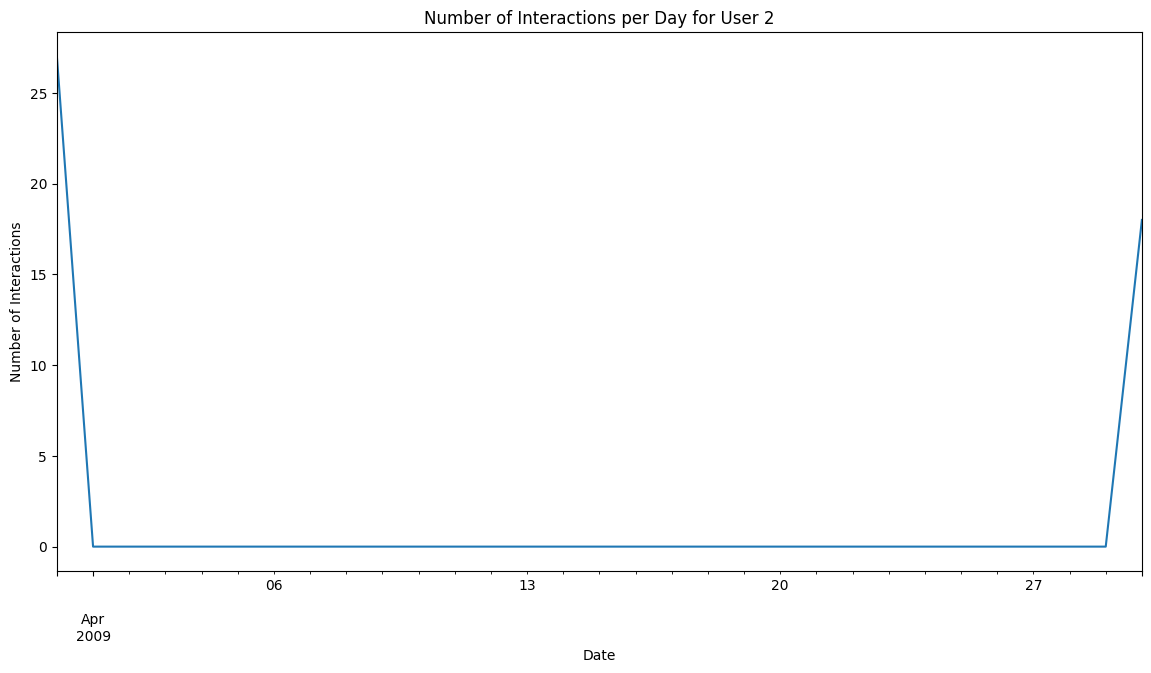

Number of unique sessions per hour:
         date  hour  session_count
0  2009-03-31    22             27
1  2009-04-30    22             18
Number of unique sessions per day:
         date  session_count
0  2009-03-31             27
1  2009-04-30             18
Number of unique sessions per week:
   week  session_count
0    14             27
1    18             18


In [ ]:
specific_user_id = 2
user_data = user_taggedartists_timestamps[user_taggedartists_timestamps['userID'] == specific_user_id]

plt.figure(figsize=(14, 7))
user_data.set_index('datetime')['artistID'].resample('D').count().plot(title='Number of Interactions per Day for User {}'.format(specific_user_id))
plt.ylabel('Number of Interactions')
plt.xlabel('Date')
plt.show()

In [ ]:
print("Number of unique sessions per hour:")
user_data.groupby(['date', 'hour']).size().reset_index(name='session_count').head()

Number of unique sessions per hour:


date  hour  session_count
0  2009-03-31    22             27
1  2009-04-30    22             18

In [ ]:
print("Number of unique sessions per day:")
user_data.groupby('date').size().reset_index(name='session_count').head()

Number of unique sessions per day:


date  session_count
0  2009-03-31             27
1  2009-04-30             18

In [ ]:
print("Number of unique sessions per week:")
user_data.groupby('week').size().reset_index(name='session_count').head()

Number of unique sessions per week:


week  session_count
0    14             27
1    18             18

### Plot the distributions of the session periods

Choose the best session period to be used for recommendations

In [ ]:
hourly_sessions = user_taggedartists_timestamps.groupby(['userID', 'date', 'hour']).size().reset_index(name='session_count')
daily_sessions = user_taggedartists_timestamps.groupby(['userID', 'date']).size().reset_index(name='session_count')
weekly_sessions = user_taggedartists_timestamps.groupby(['userID', 'week']).size().reset_index(name='session_count')
monthly_sessions = user_taggedartists_timestamps.groupby(['userID', 'year', 'month']).size().reset_index(name='session_count')

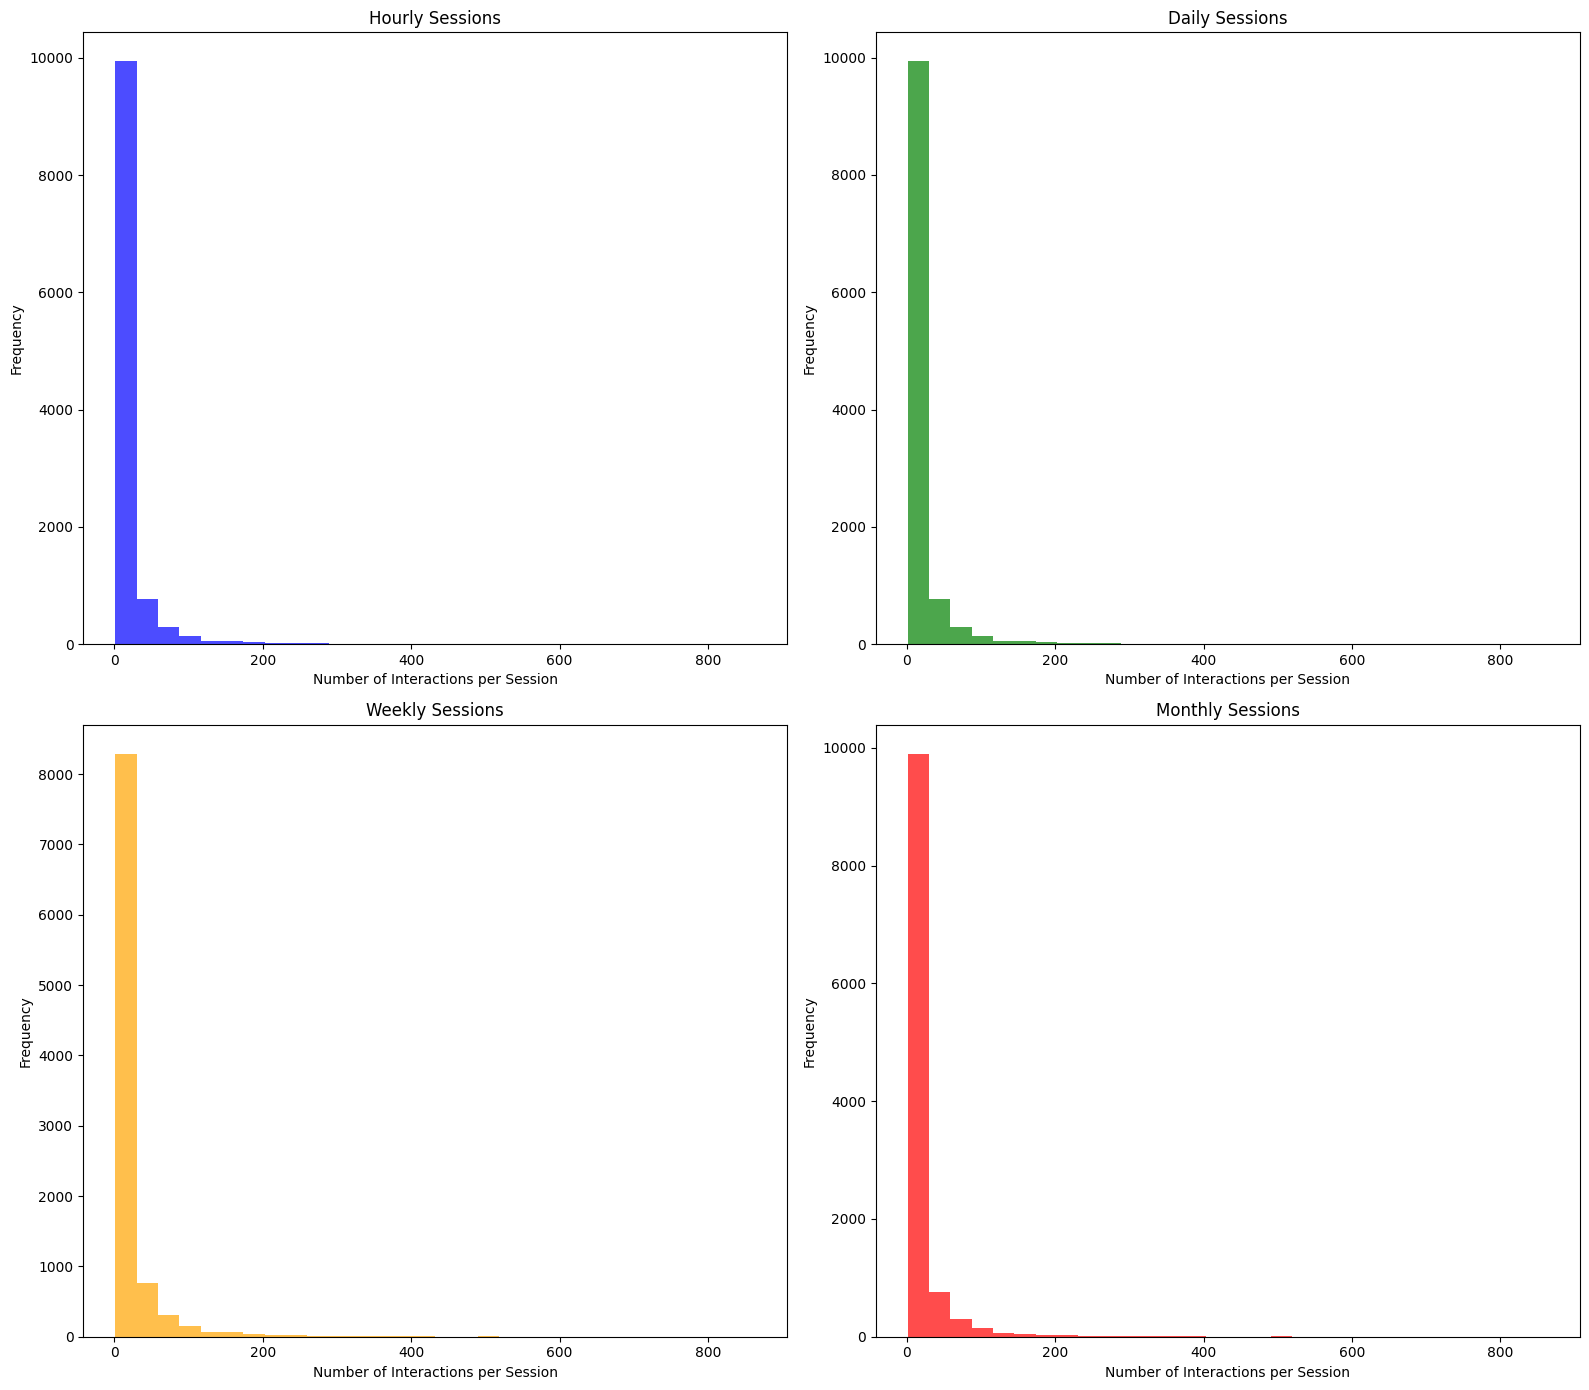

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Hourly Sessions Plot
axes[0, 0].hist(hourly_sessions['session_count'], bins=30, color='blue', alpha=0.7)
axes[0, 0].set_title('Hourly Sessions')
axes[0, 0].set_xlabel('Number of Interactions per Session')
axes[0, 0].set_ylabel('Frequency')

# Daily Sessions Plot
axes[0, 1].hist(daily_sessions['session_count'], bins=30, color='green', alpha=0.7)
axes[0, 1].set_title('Daily Sessions')
axes[0, 1].set_xlabel('Number of Interactions per Session')
axes[0, 1].set_ylabel('Frequency')

# Weekly Sessions Plot
axes[1, 0].hist(weekly_sessions['session_count'], bins=30, color='orange', alpha=0.7)
axes[1, 0].set_title('Weekly Sessions')
axes[1, 0].set_xlabel('Number of Interactions per Session')
axes[1, 0].set_ylabel('Frequency')

# Monthly Sessions Plot
axes[1, 1].hist(monthly_sessions['session_count'], bins=30, color='red', alpha=0.7)
axes[1, 1].set_title('Monthly Sessions')
axes[1, 1].set_xlabel('Number of Interactions per Session')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

All session periods on the same plot

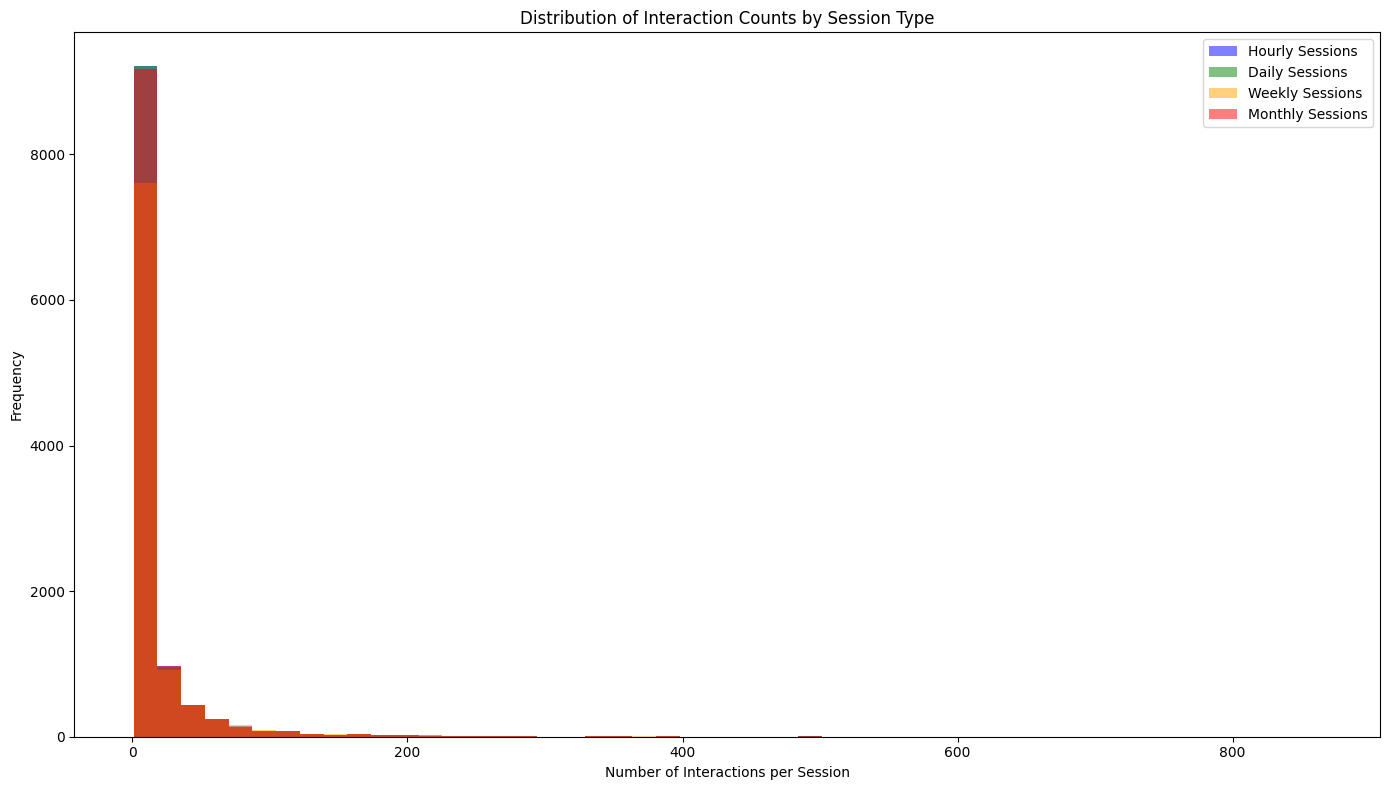

In [ ]:
plt.figure(figsize=(14, 8))

plt.hist(hourly_sessions['session_count'], bins=50, color='blue', alpha=0.5, label='Hourly Sessions')
plt.hist(daily_sessions['session_count'], bins=50, color='green', alpha=0.5, label='Daily Sessions')
plt.hist(weekly_sessions['session_count'], bins=50, color='orange', alpha=0.5, label='Weekly Sessions')
plt.hist(monthly_sessions['session_count'], bins=50, color='red', alpha=0.5, label='Monthly Sessions')

plt.title('Distribution of Interaction Counts by Session Type')
plt.xlabel('Number of Interactions per Session')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
print("Hourly Sessions Statistics")
hourly_sessions['session_count'].describe()

Hourly Sessions Statistics


count    11396.000000
mean        16.363549
std         41.735178
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        864.000000
Name: session_count, dtype: float64

In [ ]:
print("Daily Sessions Statistics")
daily_sessions['session_count'].describe()

Daily Sessions Statistics


count    11394.000000
mean        16.366421
std         41.757171
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        864.000000
Name: session_count, dtype: float64

In [ ]:
print("Weekly Sessions Statistics")
weekly_sessions['session_count'].describe()

Weekly Sessions Statistics


count    9784.000000
mean       19.059587
std        46.018187
min         1.000000
25%         2.000000
50%         5.000000
75%        16.000000
max       864.000000
Name: session_count, dtype: float64

In [ ]:
print("Monthly Sessions Statistics")
monthly_sessions['session_count'].describe()

Monthly Sessions Statistics


count    11357.000000
mean        16.419741
std         41.834730
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        864.000000
Name: session_count, dtype: float64

## Implementation

In [21]:
user_taggedartists_timestamps['timestamp'] = pd.to_datetime(user_taggedartists_timestamps['timestamp'], unit='ms')

### Create session data

In [7]:
def create_session_data(df, session_type):
    if session_type == 'hour':
        df['hour'] = df['timestamp'].dt.hour
        return df.groupby(['userID', 'artistID', 'hour']).size().reset_index(name='interaction_count')
    elif session_type == 'day':
        df['date'] = df['timestamp'].dt.date
        return df.groupby(['userID', 'artistID', 'date']).size().reset_index(name='interaction_count')
    elif session_type == 'week':
        df['week'] = df['timestamp'].dt.isocalendar().week
        return df.groupby(['userID', 'artistID', 'week']).size().reset_index(name='interaction_count')
    elif session_type == 'month':
        df['month'] = df['timestamp'].dt.to_period('M')
        return df.groupby(['userID', 'artistID', 'month']).size().reset_index(name='interaction_count')
    else:
        raise ValueError("Unsupported session type")

In [22]:
hourly_sessions = create_session_data(user_taggedartists_timestamps, 'hour')
daily_sessions = create_session_data(user_taggedartists_timestamps, 'day')
weekly_sessions = create_session_data(user_taggedartists_timestamps, 'week')
monthly_sessions = create_session_data(user_taggedartists_timestamps, 'month')

In [9]:
hourly_sessions.head()

userID  artistID  hour  interaction_count
0       2        52    22                  5
1       2        63    22                  4
2       2        73    22                  8
3       2        94    22                  8
4       2        96    22                  2

In [5]:
def create_interaction_matrix(session_data):
    num_users = session_data['userID'].nunique()
    num_artists = session_data['artistID'].nunique()
    user_mapping = {user_id: idx for idx, user_id in enumerate(session_data['userID'].unique())}
    artist_mapping = {artist_id: idx for idx, artist_id in enumerate(session_data['artistID'].unique())}

    interaction_matrix = np.zeros((num_users, num_artists))

    for _, row in session_data.iterrows():
        user_idx = user_mapping[row['userID']]
        artist_idx = artist_mapping[row['artistID']]
        interaction_matrix[user_idx, artist_idx] = row['interaction_count']

    return interaction_matrix, user_mapping, artist_mapping

In [4]:
def create_edge_index(session_data, user_mapping, artist_mapping):
    edges = []
    for _, row in session_data.iterrows():
        user_idx = user_mapping[row['userID']]
        artist_idx = artist_mapping[row['artistID']]
        edges.append((user_idx, artist_idx + len(user_mapping)))  # Shift artist indices
        edges.append((artist_idx + len(user_mapping), user_idx))  # For undirected graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

In [23]:
hourly_matrix, hourly_user_mapping, hourly_artist_mapping = create_interaction_matrix(hourly_sessions)
daily_matrix, daily_user_mapping, daily_artist_mapping = create_interaction_matrix(daily_sessions)
weekly_matrix, weekly_user_mapping, weekly_artist_mapping = create_interaction_matrix(weekly_sessions)
monthly_matrix, monthly_user_mapping, monthly_artist_mapping = create_interaction_matrix(monthly_sessions)

In [24]:
hourly_edge_index = create_edge_index(hourly_sessions, hourly_user_mapping, hourly_artist_mapping)
daily_edge_index = create_edge_index(daily_sessions, daily_user_mapping, daily_artist_mapping)
weekly_edge_index = create_edge_index(weekly_sessions, weekly_user_mapping, weekly_artist_mapping)
monthly_edge_index = create_edge_index(monthly_sessions, monthly_user_mapping, monthly_artist_mapping)

In [98]:
def create_pyg_data(matrix, edge_index):
    num_users, num_artists = matrix.shape
    num_nodes = num_users + num_artists

    # Create feature matrix (one-hot encoding for users and artists)
    x = torch.eye(num_nodes)

    # Create edge labels (1 for existing edges)
    edge_label = torch.ones(edge_index.shape[1], dtype=torch.float)

    # Create negative samples
    neg_edge_index = negative_sampling(edge_index, num_nodes=num_nodes)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], dtype=torch.float)

    # Combine positive and negative edges
    full_edge_index = torch.cat([edge_index, neg_edge_index], dim=1)
    full_edge_label = torch.cat([edge_label, neg_edge_label])

    # Shuffle edges before splitting
    num_edges = full_edge_index.shape[1]
    perm = torch.randperm(num_edges)
    full_edge_index = full_edge_index[:, perm]
    full_edge_label = full_edge_label[perm]

    # Create train and test masks for edges
    num_train = int(0.8 * num_edges)
    train_mask = torch.zeros(num_edges, dtype=torch.bool)
    test_mask = torch.zeros(num_edges, dtype=torch.bool)
    train_mask[:num_train] = True
    test_mask[num_train:] = True

    data = Data(x=x, edge_index=full_edge_index, edge_label=full_edge_label)
    data.train_mask = train_mask
    data.test_mask = test_mask

    return data

In [99]:
hourly_pyg_data = create_pyg_data(hourly_matrix, hourly_edge_index)
daily_pyg_data = create_pyg_data(daily_matrix, daily_edge_index)
weekly_pyg_data = create_pyg_data(weekly_matrix, weekly_edge_index)
monthly_pyg_data = create_pyg_data(monthly_matrix, monthly_edge_index)

### Define model

In [14]:
class GCNRecommender(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNRecommender, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

### Train and evaluate

In [101]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    out = model.decode(z, data.edge_index[:, data.train_mask])
    loss = F.binary_cross_entropy_with_logits(out, data.edge_label[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [106]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)
        out = model.decode(z, data.edge_index[:, data.test_mask])
        y_true = data.edge_label[data.test_mask].cpu().numpy()
        y_pred = out.sigmoid().cpu().numpy()

        y_pred_class = (y_pred > 0.5).astype(int)

        precision = precision_score(y_true, y_pred_class, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred_class, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred_class, average='binary', zero_division=0)
        avg_precision = average_precision_score(y_true, y_pred)

        metrics = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'average_precision': avg_precision
        }

    return metrics


#### Hourly recommendations

In [107]:
model = GCNRecommender(in_channels=hourly_pyg_data.num_features, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [108]:
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model, hourly_pyg_data, optimizer)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

Epoch 10/100, Loss: 0.5710
Epoch 20/100, Loss: 0.5207
Epoch 30/100, Loss: 0.5026
Epoch 40/100, Loss: 0.4969
Epoch 50/100, Loss: 0.4916
Epoch 60/100, Loss: 0.4890
Epoch 70/100, Loss: 0.4866
Epoch 80/100, Loss: 0.4847
Epoch 90/100, Loss: 0.4830
Epoch 100/100, Loss: 0.4814


In [109]:
hourly_metrics = evaluate_model(model, hourly_pyg_data)
print("Hourly session metrics:", hourly_metrics)

Hourly session metrics: {'precision': 0.5626043405676127, 'recall': 0.9480846609310085, 'f1_score': 0.7061632737594873, 'average_precision': 0.939442688436259}


#### Daily recommendations

In [110]:
model2 = GCNRecommender(in_channels=daily_pyg_data.num_features, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [111]:
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model2, daily_pyg_data, optimizer)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

Epoch 10/100, Loss: 0.6931
Epoch 20/100, Loss: 0.6931
Epoch 30/100, Loss: 0.6931
Epoch 40/100, Loss: 0.6931
Epoch 50/100, Loss: 0.6931
Epoch 60/100, Loss: 0.6931
Epoch 70/100, Loss: 0.6931
Epoch 80/100, Loss: 0.6931
Epoch 90/100, Loss: 0.6931
Epoch 100/100, Loss: 0.6931


In [112]:
daily_metrics = evaluate_model(model, daily_pyg_data)
print("Daily session metrics:", daily_metrics)

Daily session metrics: {'precision': 0.5443685723304923, 'recall': 0.9628269174258007, 'f1_score': 0.6955072756025854, 'average_precision': 0.9412641870078879}


#### Weekly recommendations

In [113]:
model3 = GCNRecommender(in_channels=weekly_pyg_data.num_features, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

In [114]:
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model3, weekly_pyg_data, optimizer)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

Epoch 10/100, Loss: 0.5701
Epoch 20/100, Loss: 0.5178
Epoch 30/100, Loss: 0.5001
Epoch 40/100, Loss: 0.4943
Epoch 50/100, Loss: 0.4892
Epoch 60/100, Loss: 0.4866
Epoch 70/100, Loss: 0.4843
Epoch 80/100, Loss: 0.4824
Epoch 90/100, Loss: 0.4808
Epoch 100/100, Loss: 0.4793


In [115]:
weekly_metrics = evaluate_model(model3, weekly_pyg_data)
print("Daily session metrics:", weekly_metrics)

Daily session metrics: {'precision': 0.567716796840873, 'recall': 0.9528431918824599, 'f1_score': 0.7115077192598269, 'average_precision': 0.941584909019057}


#### Monthly recommendations

In [116]:
model4 = GCNRecommender(in_channels=monthly_pyg_data.num_features, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)

In [117]:
num_epochs = 100
for epoch in range(num_epochs):
    loss = train(model4, monthly_pyg_data, optimizer)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

Epoch 10/100, Loss: 0.5736
Epoch 20/100, Loss: 0.5179
Epoch 30/100, Loss: 0.4991
Epoch 40/100, Loss: 0.4936
Epoch 50/100, Loss: 0.4889
Epoch 60/100, Loss: 0.4861
Epoch 70/100, Loss: 0.4838
Epoch 80/100, Loss: 0.4820
Epoch 90/100, Loss: 0.4804
Epoch 100/100, Loss: 0.4790


In [122]:
monthly_metrics = evaluate_model(model3, monthly_pyg_data)
print("Monthly session metrics:", monthly_metrics)

Monthly session metrics: {'precision': 0.5457923679386769, 'recall': 0.9608930352637447, 'f1_score': 0.6961613671144363, 'average_precision': 0.9411490430728773}


### Results

In [119]:
def print_metrics(metrics, session_type):
    print(f"\n{session_type.capitalize()} Session Metrics:")
    print("-" * (len(session_type) + 16))
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title():<20}: {value:.4f}")

In [120]:
session_types = ['hourly', 'daily', 'weekly', 'monthly']
results_dict = {
    'hourly': hourly_metrics,
    'daily': daily_metrics,
    'weekly': weekly_metrics,
    'monthly': monthly_metrics
}

In [121]:
for session_type, metrics in results_dict.items():
    print_metrics(metrics, session_type)


Hourly Session Metrics:
----------------------
Precision           : 0.5626
Recall              : 0.9481
F1 Score            : 0.7062
Average Precision   : 0.9394

Daily Session Metrics:
---------------------
Precision           : 0.5444
Recall              : 0.9628
F1 Score            : 0.6955
Average Precision   : 0.9413

Weekly Session Metrics:
----------------------
Precision           : 0.5677
Recall              : 0.9528
F1 Score            : 0.7115
Average Precision   : 0.9416

Monthly Session Metrics:
-----------------------
Precision           : 0.5458
Recall              : 0.9609
F1 Score            : 0.6962
Average Precision   : 0.9411
